In [45]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import progressbar
from smo import *
from mySVM_class import *
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
train = pd.read_csv('Data/train.csv', nrows = 2000)

In [47]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100
train_labels = np.array(train['label'])
label_even = np.array([1 if i in [0, 2, 3,4, 5,6, 7] else -1 for i in train_labels]) #All even numbers get the label 1, the odd ones get -1

## Linear Kernel
In order to find out which C yields the qualitatively best classifiert, we determine for several values of C a score ($score=\frac{\#correct}{\#all}$).
For each of these values, we separate the data randomly into trainings data and test data multiple times, and cross-validate each time using this partition. Afterwards, we average over these multiple scores and compare the outcome for the different values of C.

In [5]:
%%time

no_samples = 400
scores_list = []
no_itereations = 1

C_list = [16., 18. , 20., 22.]
with progressbar.ProgressBar(max_value=len(C_list)*no_itereations) as bar:
    bar.update(0)
    for i in range(no_itereations):
        scores_list.append([])
        for C in C_list:
            scores_list[i].append(cross_validation(train_images[:no_samples],label_even[:no_samples], C, scalar_product))
            bar.update(C_list.index(C)*(i+1))
print(scores_list)

100% (4 of 4) |###########################| Elapsed Time: 0:00:09 Time: 0:00:09


KeyboardInterrupt: 

In [34]:
S = np.mean(scores_list, axis = 0)
S

array([ 0.813,  0.818,  0.837,  0.832])

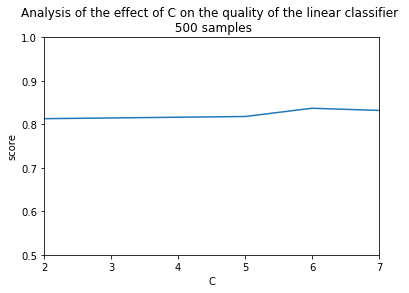

In [35]:
figure_parameterC = plt.figure();
plt.plot(C_list, S);
#plt.xscale('log');
plt.ylim([0.5,1]);
plt.xlim([2,7]);

plt.title('Analysis of the effect of C on the quality of the linear classifier \n 500 samples');
plt.xlabel('C');
plt.ylabel('score');
#plt.savefig('CAnalysis_linear.pdf')

Observation: C has no noticeable effect on the quality of a linear classifier.

## Crossvalidating ECOC with Linear Kernel

In [7]:
%%time

no_samples = 400
penalty = 6.
score = cross_validation_ecoc(train_images[:no_samples], train_labels[:no_samples], penalty)
print(score)

KeyboardInterrupt: 

## Parameteroptimization for ecoc with Gaussian Kernel

In [73]:
code_words=np.array([
        [ 1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1],
        [-1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1],
        [ 1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1],
        [-1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1],
        [ 1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1],
        [-1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,  1],
        [ 1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1],
        [-1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1]])

100% (15 of 15) |#########################| Elapsed Time: 2:32:07 Time: 2:32:07


Wall time: 2h 32min 7s


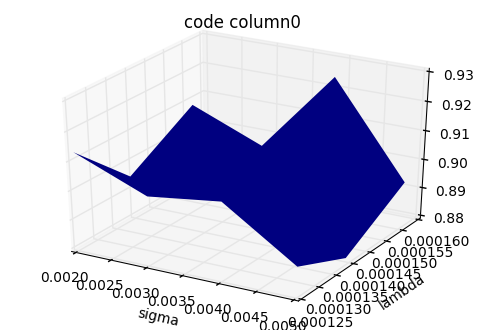

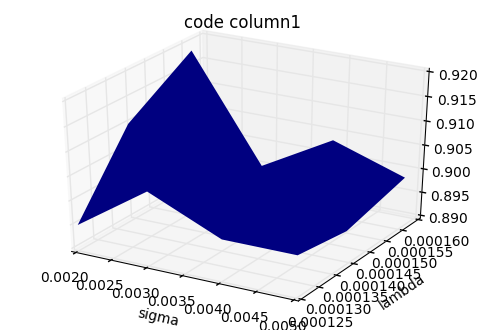

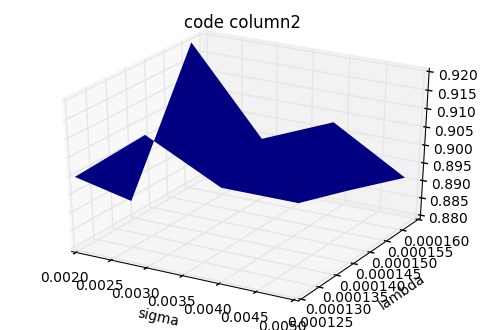

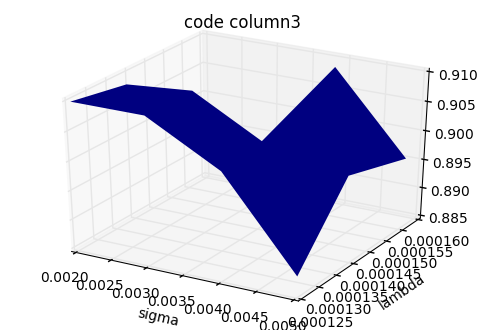

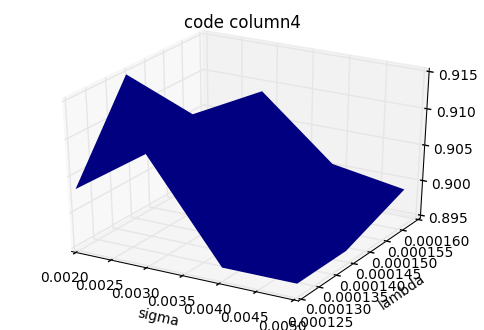

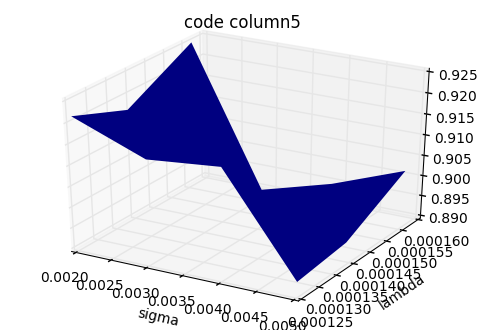

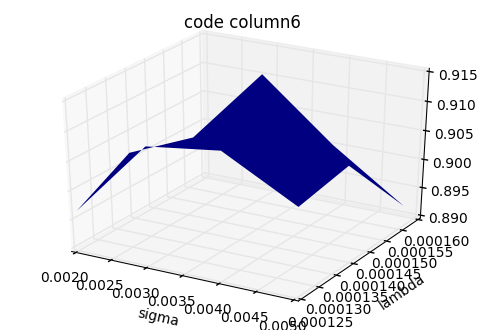

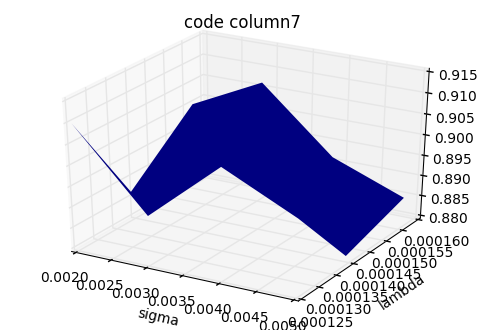

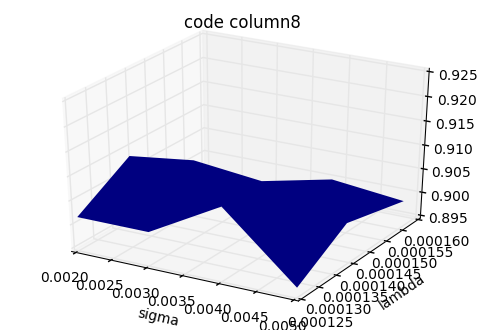

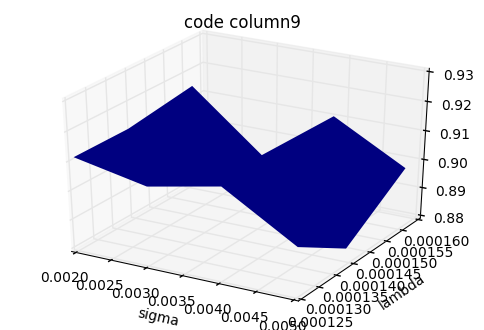

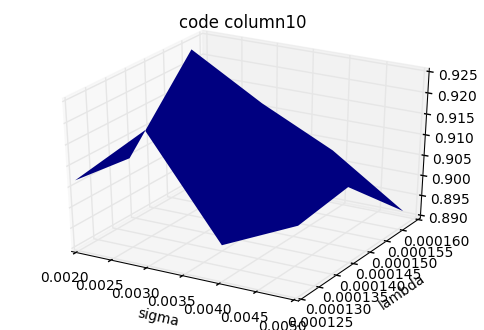

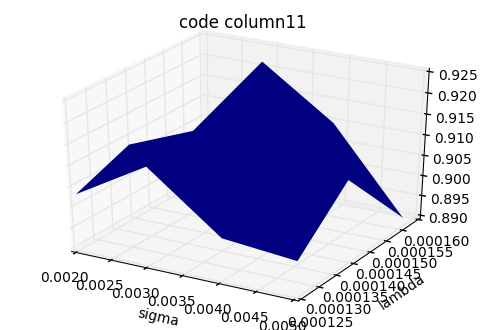

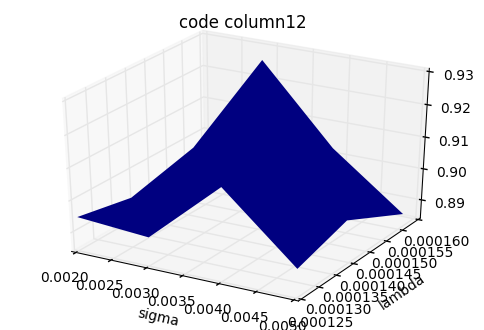

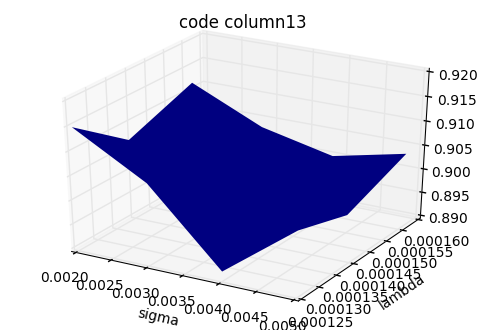

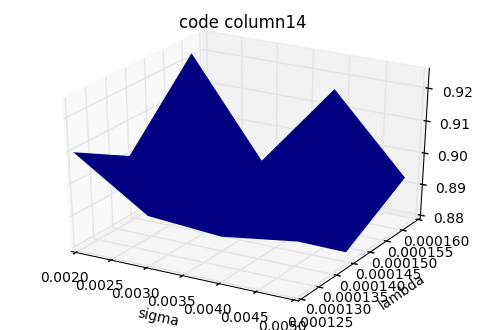

In [104]:
%%time
no_itereations = 1
no_samples = 600
lambda_list = 1./(400*np.array([16., 18., 20.]))
C_list = 1./(2*no_samples*lambda_list)
sigma_list = np.array([0.002, 0.003, 0.004, 0.005])

figures = []
Zmatrices = []
sigma_grid, lambda_grid = np.meshgrid(sigma_list, lambda_list)

with progressbar.ProgressBar(max_value=15) as bar:
    bar.update(0)
    for column in range(15):
        scores_list = []
        group1 = [i for i in range(len(code_words)) if code_words[i,column]==1] #digits with label 1
        label_code = np.array([1 if i in group1 else -1 for i in train_labels[:no_samples]]) #All even numbers get the label 1, the odd ones get -1
        for i in range(no_itereations):
            scores_list.append([])
            for C in C_list:
                templist = []
                for sigma in sigma_list:
                    templist.append(cross_validation(train_images[:no_samples],label_even[:no_samples], C, gaussian_kernel, sigma=sigma))
                scores_list[i].append(templist)
        mean_scores = np.mean(scores_list, axis = 0)
        Z = np.array(mean_scores)
        Z = np.reshape(Z, np.shape(lambda_grid))
        figure_ParameterCsigma = plt.figure()
        ax = figure_ParameterCsigma.gca(projection='3d')
        surf = ax.plot_surface(sigma_grid, lambda_grid, Z,
                               linewidth=0, antialiased=False)
        plt.title('code column' + str(column))
        plt.xlabel('sigma')
        plt.ylabel('lambda')
        figures.append(figure_ParameterCsigma)
        Zmatrices.append(Z)
        bar.update(column)

In [105]:
pickle.dump((Zmatrices, figures, lambda_list, sigma_list), open( "Paramter_opt_600samplesCrossVal.dat", "wb" ))

In [106]:
Zmatrices


[array([[ 0.90833333,  0.89833333,  0.92666667,  0.895     ],
        [ 0.895     ,  0.88666667,  0.89833333,  0.88166667],
        [ 0.91333333,  0.90333333,  0.90666667,  0.89      ]]),
 array([[ 0.91833333,  0.89666667,  0.905     ,  0.9       ],
        [ 0.91      ,  0.91333333,  0.90333333,  0.89666667],
        [ 0.895     ,  0.905     ,  0.89833333,  0.89833333]]),
 array([[ 0.92      ,  0.89666667,  0.905     ,  0.89333333],
        [ 0.885     ,  0.90166667,  0.91166667,  0.9       ],
        [ 0.9       ,  0.915     ,  0.905     ,  0.905     ]]),
 array([[ 0.90166667,  0.895     ,  0.91      ,  0.89666667],
        [ 0.90833333,  0.90333333,  0.90833333,  0.9       ],
        [ 0.91      ,  0.91      ,  0.90333333,  0.88833333]]),
 array([[ 0.905     ,  0.91      ,  0.90166667,  0.9       ],
        [ 0.915     ,  0.91      ,  0.90166667,  0.89666667],
        [ 0.90333333,  0.91      ,  0.89666667,  0.89666667]]),
 array([[ 0.925     ,  0.89166667,  0.89666667,  0.90333333]

In [139]:
lambda_opt = []
sigma_opt = []
for Z in Zmatrices:
    m = np.argmax(Z)
    sigma_opt.append(sigma_list[m%4])
    lambda_opt.append(lambda_list[m/4])
pickle.dump((lambda_opt, sigma_opt), open( "lambdasigma_opt.dat", "wb" ))


C:\Users\LMatt\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
